In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# Define constants
IMAGE_SIZE = (224, 224)  # Ensure size is 224x224
BATCH_SIZE = 16
EPOCHS = 50
DATA_PATH = "/kaggle/input/dfudata"

# Define paths
TRAIN_IMG_PATH = os.path.join(DATA_PATH, "train/images")
TRAIN_MASK_PATH = os.path.join(DATA_PATH, "train/labels")

VAL_IMG_PATH = os.path.join(DATA_PATH, "validation/images")
VAL_MASK_PATH = os.path.join(DATA_PATH, "validation/labels")

TEST_IMG_PATH = os.path.join(DATA_PATH, "test/images")


In [2]:
def load_data(image_folder, mask_folder=None, image_size=IMAGE_SIZE):
    images, masks = [], []
    
    image_files = sorted(os.listdir(image_folder))
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        images.append(img)

        if mask_folder:
            mask_path = os.path.join(mask_folder, img_file)  # Assuming same filename
            mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0
            masks.append(mask)

    return (np.array(images), np.array(masks)) if mask_folder else np.array(images)

# Load train and validation sets
X_train, Y_train = load_data(TRAIN_IMG_PATH, TRAIN_MASK_PATH)
X_val, Y_val = load_data(VAL_IMG_PATH, VAL_MASK_PATH)

# Load test images (without masks)
X_test = load_data(TEST_IMG_PATH)

print(f"Train Data: {X_train.shape}, Masks: {Y_train.shape}")
print(f"Validation Data: {X_val.shape}, Masks: {Y_val.shape}")
print(f"Test Data: {X_test.shape}")


Train Data: (810, 224, 224, 3), Masks: (810, 224, 224, 1)
Validation Data: (200, 224, 224, 3), Masks: (200, 224, 224, 1)
Test Data: (200, 224, 224, 3)


In [3]:
def unet_model(input_size=IMAGE_SIZE + (3,)):  # (224,224,3)
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    concat1 = concatenate([conv3, up1], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(concat1)
    conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    concat2 = concatenate([conv2, up2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(concat2)
    conv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    concat3 = concatenate([conv1, up3], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(concat3)
    conv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv7)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(conv7)  # Sigmoid for binary segmentation

    model = Model(inputs, outputs)
    return model

# Compile Model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 56, 56, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 768)    │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 112, 112, 256)  │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 69s 854ms/step - accuracy: 0.9702 - loss: 0.3815 - val_accuracy: 0.9877 - val_loss: 0.0603
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9871 - loss: 0.0558 - val_accuracy: 0.9877 - val_loss: 0.0506
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9870 - loss: 0.0516 - val_accuracy: 0.9877 - val_loss: 0.0417
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9873 - loss: 0.0408 - val_accuracy: 0.9877 - val_loss: 0.0392
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9873 - loss: 0.0382 - val_accuracy: 0.9889 - val_loss: 0.0296
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.9897 - loss: 0.0325 - val_accuracy: 0.9909 - val_loss: 0.0289
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9909 - loss: 0.0283 - val_accuracy: 0.9914 - val_loss: 0.0269
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9908 - loss: 0.0302 - val_accu

In [5]:
loss, accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Compute Mean IoU
y_pred = model.predict(X_val)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(Y_val, y_pred_thresholded)
print(f"Mean IoU: {iou_metric.result().numpy():.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.9961 - loss: 0.0181
Validation Loss: 0.0192
Validation Accuracy: 0.9961
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step
Mean IoU: 0.8543


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


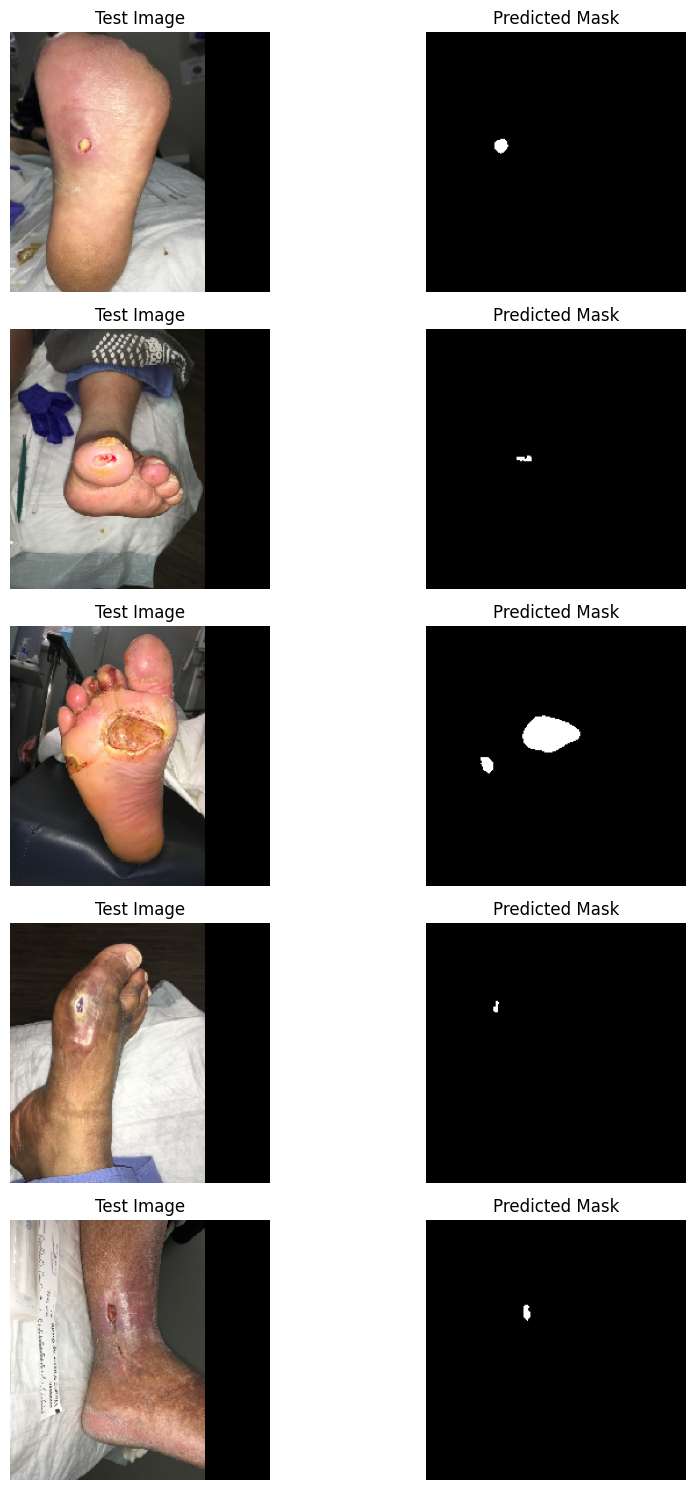

In [6]:
def test_predictions(model, X_test, num_samples=5):
    indices = np.random.choice(len(X_test), num_samples)

    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title("Test Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

test_predictions(model, X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


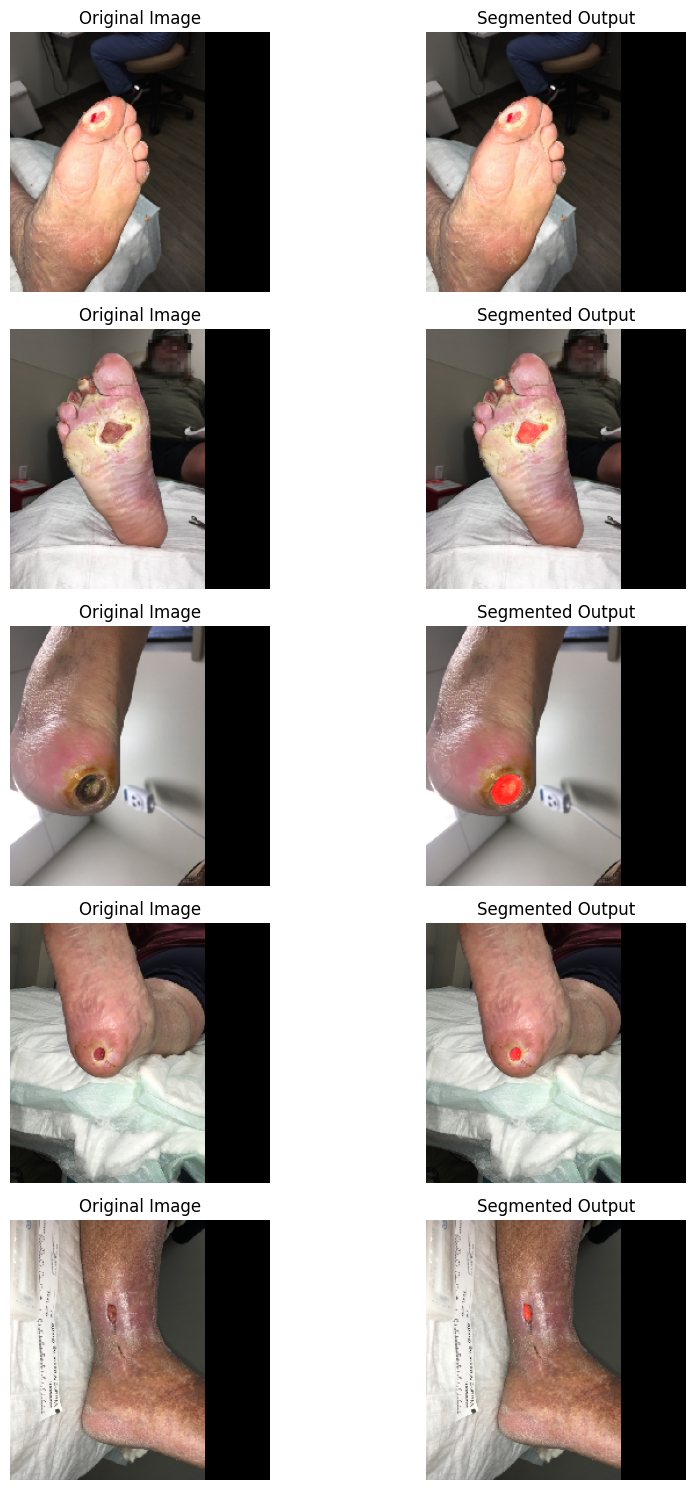

In [7]:
def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlays the predicted segmentation mask on the original image.

    Parameters:
    - image: Original image (numpy array, shape (224, 224, 3))
    - mask: Predicted mask (numpy array, shape (224, 224, 1))
    - color: RGB tuple for overlay color (default: Red)
    - alpha: Transparency level of overlay (default: 0.5)

    Returns:
    - Blended image with mask overlayed in red.
    """
    mask = np.squeeze(mask)  # Remove extra dimensions
    mask = (mask > 0.5).astype(np.uint8)  # Threshold mask (binary)

    # Convert grayscale mask to 3-channel
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * color[0]  # Red channel
    mask_colored[:, :, 1] = mask * color[1]  # Green channel
    mask_colored[:, :, 2] = mask * color[2]  # Blue channel

    # Blend original image and mask
    overlayed = cv2.addWeighted(image, 1, mask_colored, alpha, 0)
    
    return overlayed

def test_predictions(model, X_test, num_samples=5):
    """
    Runs the model on test images and overlays segmentation results.
    """
    indices = np.random.choice(len(X_test), num_samples)

    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Get overlayed image
        overlayed_img = overlay_mask_on_image(img, pred_mask)

        # Plot original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        # Plot image with segmentation overlay
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(overlayed_img)
        plt.title("Segmented Output")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the function to visualize results
test_predictions(model, X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


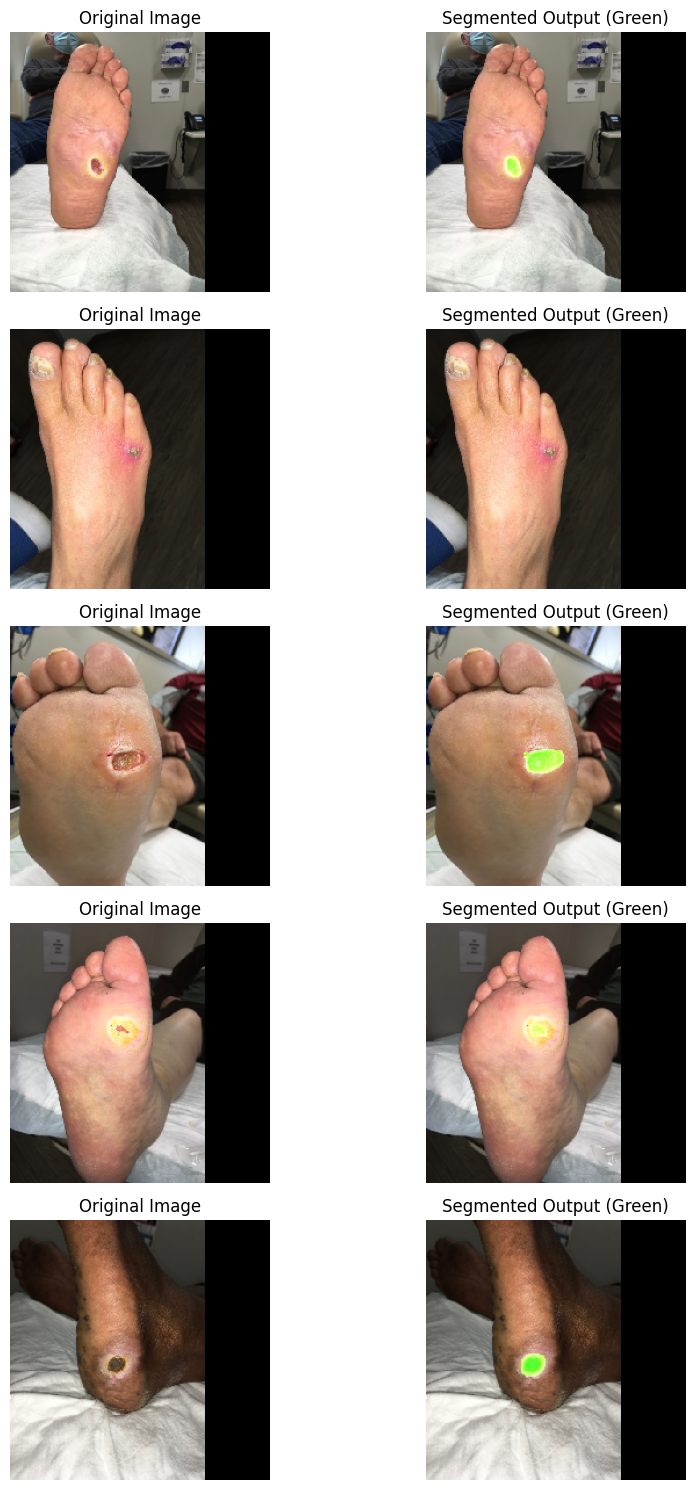

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_mask(mask, threshold=0.3, kernel_size=5, blur=True):
    """
    Processes the predicted mask to ensure it fully covers the ulcer.
    """
    mask = np.squeeze(mask)  # Remove extra dimensions
    mask = (mask > threshold).astype(np.uint8)  # Apply lower threshold

    # Morphological closing to fill gaps
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Optional: Apply Gaussian blur to smooth the edges
    if blur:
        mask = cv2.GaussianBlur(mask.astype(np.float32), (5, 5), 0)

    return mask

def overlay_mask_on_image(image, mask, color=(0, 255, 0), alpha=0.5):
    """
    Overlays the processed segmentation mask on the original image.
    Color changed to GREEN (0, 255, 0).
    """
    mask = process_mask(mask)  # Apply mask processing
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * color[0]  # Blue channel
    mask_colored[:, :, 1] = mask * color[1]  # Green channel
    mask_colored[:, :, 2] = mask * color[2]  # Red channel

    # Blend original image and mask
    overlayed = cv2.addWeighted(image, 1, mask_colored, alpha, 0)

    return overlayed

def test_predictions(model, X_test, num_samples=5):
    """
    Runs the model on test images and overlays segmentation results.
    """
    indices = np.random.choice(len(X_test), num_samples)

    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Get overlayed image with GREEN mask
        overlayed_img = overlay_mask_on_image(img, pred_mask)

        # Plot original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        # Plot image with segmentation overlay (Green)
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(overlayed_img)
        plt.title("Segmented Output (Green)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the function to visualize results
test_predictions(model, X_test)


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model (if not already loaded)
# model = load_model("path_to_your_model.h5")  # Uncomment if needed

def load_and_preprocess_image(image_path, img_size=224):
    """
    Loads and preprocesses an image for model inference.
    """
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (img_size, img_size))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values (0-1)
    return img

def process_mask(mask, threshold=0.3, kernel_size=5, blur=True):
    """
    Processes the predicted mask to fully cover the ulcer.
    """
    mask = np.squeeze(mask)
    mask = (mask > threshold).astype(np.uint8)  # Lower threshold for better coverage

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Fill small holes

    if blur:
        mask = cv2.GaussianBlur(mask.astype(np.float32), (5, 5), 0)  # Smooth edges

    return mask

def overlay_mask_on_image(image, mask, color=(0, 255, 0), alpha=0.5):
    """
    Overlays the predicted segmentation mask on the original image.
    """
    mask = process_mask(mask)  # Process mask
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 1] = mask * color[1]  # Green channel

    overlayed = cv2.addWeighted(image, 1, mask_colored, alpha, 0)  # Blend image & mask
    return overlayed

def test_single_image(model, image_path):
    """
    Tests a single external image and displays the segmented output.
    """
    img = load_and_preprocess_image(image_path)
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]  # Predict mask

    overlayed_img = overlay_mask_on_image(img, pred_mask)  # Get final output

    # Display results
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_img)
    plt.title("Segmented Output (Green)")
    plt.axis("off")

    plt.show()

# Example usage:
# test_single_image(model, "/kaggle/input/your_test_image.jpg")


In [12]:
# Save the trained model
model.save("/kaggle/working/ulcer_segmentation_model.h5")


In [13]:
from tensorflow.keras.models import load_model

# Load the trained segmentation model
pretrained_model = load_model("/kaggle/working/ulcer_segmentation_model.h5")
